## Analyses for Figure 4e and related Extended Data Figures

In [ ]:
import numpy as np
import pandas as pd
import gseapy as gp
import dynamo as dyn

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
gtf_data = pd.read_csv("../../data/HCMV_moDC/hcmv_intronannotation.gtf", sep="\t", header=None)
gtf_data[8] = gtf_data[8].str.extract(r'gene_id "([^"]+)"')
viral_genes_names = gtf_data[8].unique()
viral_genes_names = np.delete(viral_genes_names, np.where(viral_genes_names=='UL38'))
len(viral_genes_names)

66

In [3]:
viral_adata = dyn.read('adata_gv.h5ad')
viral_adata = viral_adata[viral_adata.obs.annot=='I']
viral_adata

View of AnnData object with n_obs × n_vars = 975 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_Protein', 'nFeature_Protein', 'batch', 'percent.mt', 'Demultiplex', 'TotalVir', 'TotalVirPercentage', 'CD45', 'HLA.DR', 'HCMV.Status', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'clusters', 'donor', 'Cluster.Type', 'annot', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'spliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_spliced_cell_size', 'initial_cell_size', 'unspliced_Size_Factor', 'ntr', 'cell_cycle_phase', 'correlation_velocity_confidence'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'log_m', 'log_cv', 'frac', 'use_for_pca', 'ntr', 'use_for_dynamics', 'use_for_transition', 'Mac_score'
    uns: 'PCs', 'cell_phase_genes', 'cell_phase_order', 'dynamics', 'explained_variance_ratio_', 'feature_selection', 'genes_to_use', 'grid_velocity_umap', 'neighbors', 'pca_fit', 'pca_mean', 'pp', 'vel_params_names

In [4]:
viral_genes_names = [i for i in viral_genes_names if i in viral_adata.var_names]

In [5]:
speed = np.linalg.norm(viral_adata[:, viral_genes_names].layers['velocity_gv'].A, axis=1)
viral_adata.obs['vir_speed'] = speed

## Visualize speed trends along % viral RNA-axis

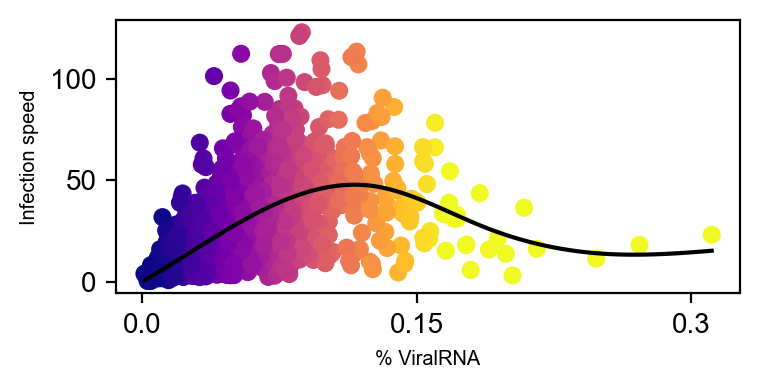

In [7]:
from pygam import LinearGAM, s
from matplotlib import cm
from matplotlib.colors import Normalize
t = viral_adata.obs['TotalVirPercentage']
x = viral_adata.obs['vir_speed']

norm = Normalize(vmin=np.quantile(t, 0.05), vmax=np.quantile(t, 0.98))
plasma_cmap = cm.plasma
mapped_colors = plasma_cmap(norm(t))
term  =s(
    0,
    spline_order=3,
    n_splines=8
)
gam = LinearGAM(term, max_iter=1000, verbose=False).fit(t, x)
tx = gam.generate_X_grid(term=0)
fig, ax = plt.subplots(1, 1, figsize=(4, 1.8))
ax.plot(tx[:, 0], gam.predict(tx), c='black')
plt.scatter(t, x, c=mapped_colors)
plt.xticks([0, 0.15, 0.3])
plt.yticks([0, 50, 100])
plt.xlabel('% ViralRNA')
plt.ylabel('Infection speed')
ax.set_xticklabels(ax.get_xticks(), fontsize=10)
ax.set_yticklabels(ax.get_yticks(), fontsize=10)
# plt.savefig('figures_sup/viral_speed.pdf', dpi=300, transparent=True)
plt.show()

In [8]:
from tqdm import tqdm
from scipy.stats import spearmanr
speed_corr = np.zeros(viral_adata.n_vars)
speed_p = np.zeros(viral_adata.n_vars)
for i, g in tqdm(enumerate(viral_adata.var_names)):
    res = spearmanr(viral_adata.obs['vir_speed'], viral_adata[:, g].X.A.flatten())
    speed_corr[i] = res.statistic
    speed_p[i] = res.pvalue

2000it [00:03, 530.28it/s]


In [9]:
cor = pd.DataFrame(
    {'speed_corr': speed_corr, 'pval': speed_p, 'gene_name':viral_adata.var_names})

In [10]:
cor['rank'] = cor['speed_corr'].rank(ascending=False)

In [11]:
# Gene list collected from PMC8720285
# UL42-44, UL112, UL123+mNeon, UL25, UL26-30, US22
# TP53BP1, PRKDC, SMARCC1, BAZ1B, POLR1A, UBTF, PSIP1
# IFI16, TRIM25, IFIT1, IFIT2
genes = ['UL42-44', 'UL112', 'UL123+mNeon', 'UL25', 'UL26-30', 'US22',
         'TP53BP1', 'PRKDC', 'SMARCC1', 'BAZ1B', 'POLR1A', 'UBTF', 'PSIP1',
         'IFI16', 'TRIM25', 'IFIT1', 'IFIT2']
cor[cor['gene_name'].isin(genes)].sort_values('rank')

,speed_corr,pval,gene_name,rank
1968,0.571608,1.153576e-85,US22,8.0
1975,0.523007,1.474035e-69,UL26-30,15.0
1979,0.496118,1.034424e-61,UL42-44,25.0
1950,0.411392,4.125173e-41,UL25,37.0
1961,0.309676,4.095619e-23,UL112,54.0
1994,0.203240,1.503668e-10,UL123+mNeon,94.0
1596,0.089180,5.326153e-03,SMARCC1,373.0
1326,0.022779,4.774292e-01,PSIP1,787.0
1824,-0.002467,9.386844e-01,UBTF,955.0
798,-0.056018,8.041290e-02,IFIT2,1290.0


In [12]:
cor[cor['gene_name']==g]['rank']

1999    26.0
Name: rank, dtype: float64

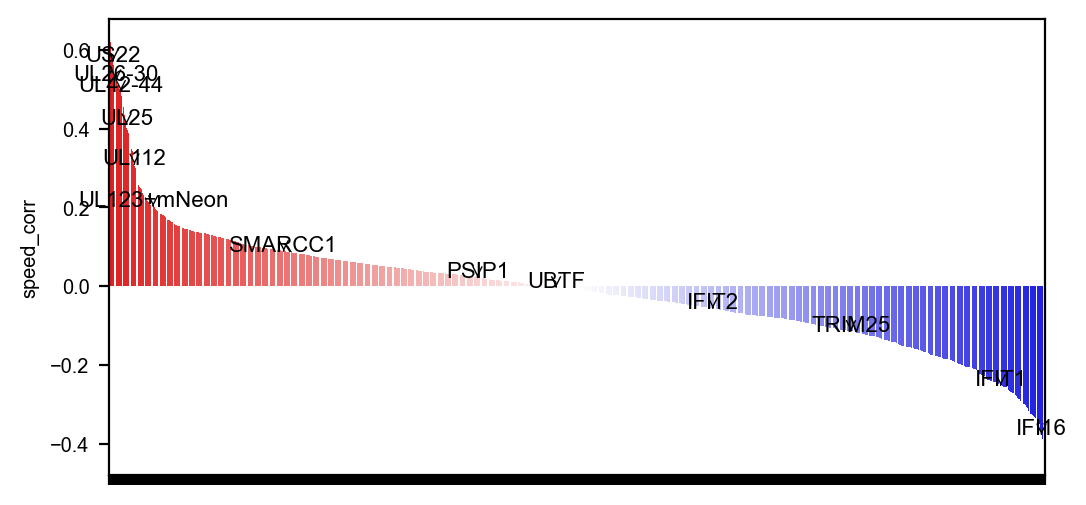

In [ ]:
plt.figure(figsize=(6, 3))
ax = sns.barplot(x='gene_name', y='speed_corr', data = cor.sort_values('speed_corr', ascending=False), palette='bwr_r')
for g in genes:
    if g not in cor['gene_name'].to_list():
        continue
    plt.annotate(g, 
                 (cor[cor['gene_name']==g]['rank'].values[0], cor[cor['gene_name']==g]['speed_corr'].values[0]), 
                 xycoords='data',
                 ha='center', 
                 fontsize=8,
                 arrowprops=dict(arrowstyle="->"))

ax.set_xlabel('')
ax.set_xticklabels([])
# plt.savefig('figures_v2/speed_corr.pdf', dpi=300, transparent=True)
plt.show()

## Functional analysis of top positive/negative correlated host genes

In [ ]:
host_gene_pos = [i for i in cor.sort_values('speed_corr').tail(110)['gene_name'].values if i not in viral_genes_names]
host_gene_neg = [i for i in cor.sort_values('speed_corr').head(50)['gene_name'].values if i not in viral_genes_names]
len(host_gene_pos), len(host_gene_neg)

(50, 50)

In [15]:
enr = gp.enrichr(host_gene_pos, gene_sets='GO_Biological_Process_2021', outdir=None)
enr_neg = gp.enrichr(host_gene_neg, gene_sets='GO_Biological_Process_2021', outdir=None)

In [16]:
enr.res2d.Term = enr.res2d.Term.str.split(" \(GO").str[0]
enr_neg.res2d.Term = enr_neg.res2d.Term.str.split(" \(GO").str[0]
enr.res2d['POS_NEG'] = 'Positive'
enr_neg.res2d['POS_NEG'] = 'Negative'
enr_res = pd.concat([enr.res2d.head(), enr_neg.res2d.head()])

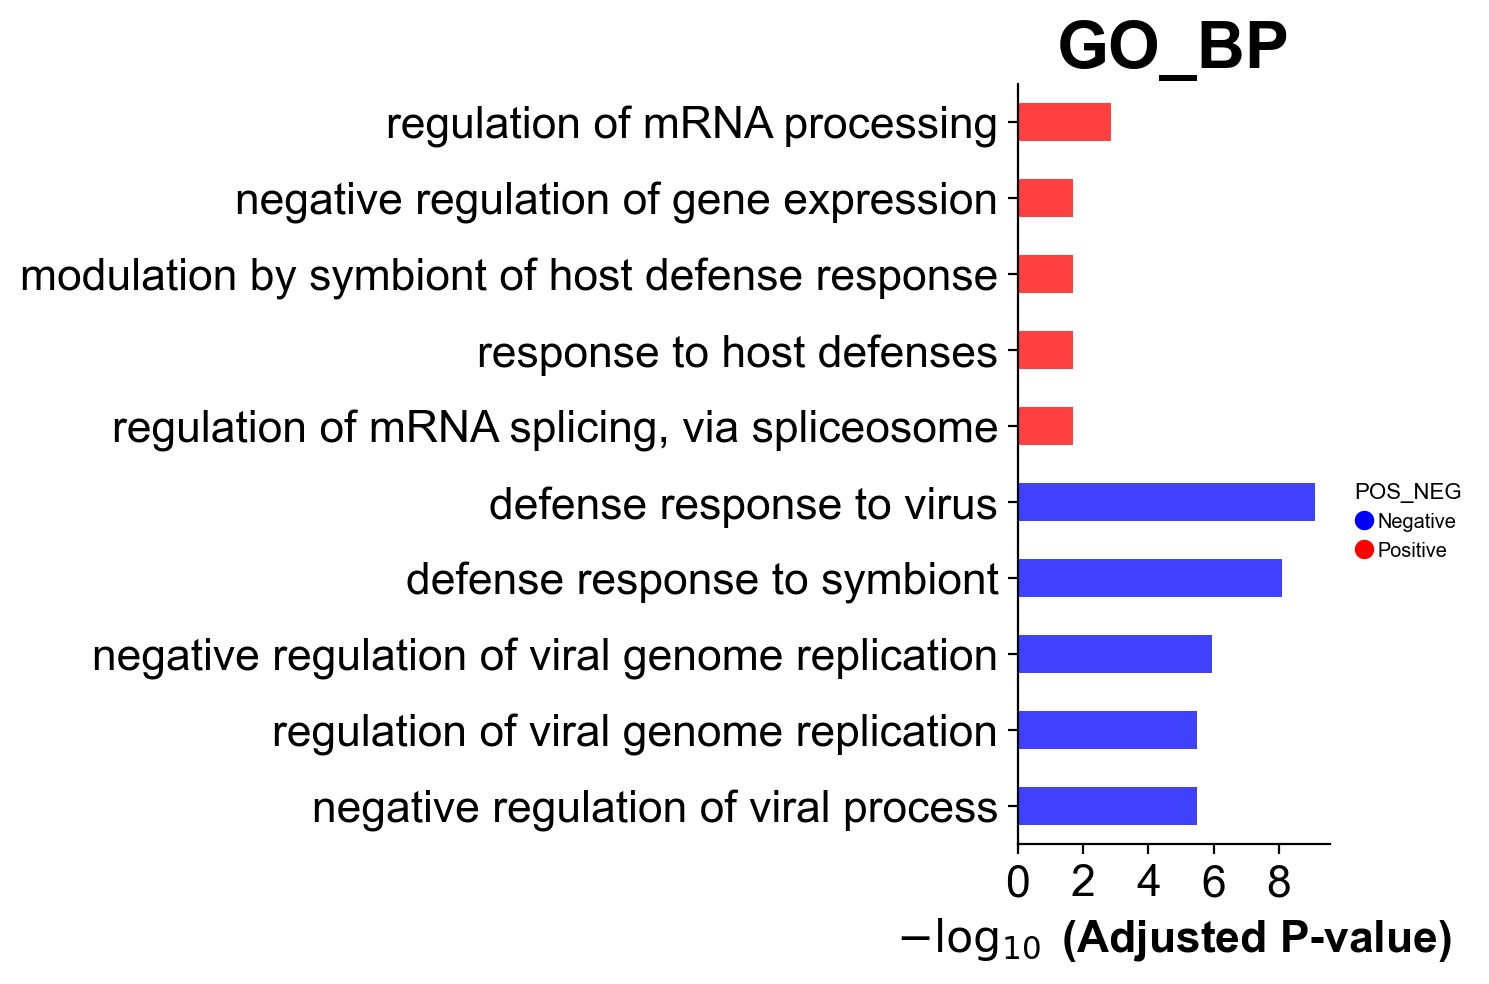

In [17]:
ax = gp.barplot(enr_res, figsize=(2, 5),
                group ='POS_NEG',
                title ="GO_BP",
                color = ['b', 'r'])
# plt.savefig(dpi=300, transparent=True, fname=f'./figures_sup/speed_cor_gsea.pdf', bbox_inches = "tight")
plt.show()